#  **AIRBNB Data Analysis Project**
*How can Airbnb identify and address supply shortages in Copenhagen's rental market to optimize host engagement and meet increasing demand effectively?*

**Author**: Dario Lucas Patzi Chavez (ID: 177125), Mikael Karlsen Hauglid (ID: 177121), Nikolay Georgiev Varamezov(ID: 176191), Sander Thomasrud(ID: 176169)

**Course**: KAN-CDSCO2303U  Data Management and Visualization


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# 1. Data Collection

In [74]:
path = "DMV_Final_Project/Data"

In [75]:
listings = pd.read_csv(path + "/listings2024.csv")
reviews = pd.read_csv(path + "/reviews2024.csv")
calendar = pd.read_csv(path + "/calendar2024.csv")

# 2. Data Description 

In [76]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20909 entries, 0 to 20908
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20909 non-null  int64  
 1   listing_url                                   20909 non-null  object 
 2   scrape_id                                     20909 non-null  int64  
 3   last_scraped                                  20909 non-null  object 
 4   source                                        20909 non-null  object 
 5   name                                          20909 non-null  object 
 6   description                                   20235 non-null  object 
 7   neighborhood_overview                         8984 non-null   object 
 8   picture_url                                   20909 non-null  object 
 9   host_id                                       20909 non-null 

In [77]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366636 entries, 0 to 366635
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     366636 non-null  int64 
 1   id             366636 non-null  int64 
 2   date           366636 non-null  object
 3   reviewer_id    366636 non-null  int64 
 4   reviewer_name  366636 non-null  object
 5   comments       366619 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.8+ MB


In [78]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7631731 entries, 0 to 7631730
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 407.6+ MB


# 3. Exploratory Data Analysis and Verification

## 3.1 Null values

In [79]:
# Display information about null values in each DataFrame, showing only columns with non-zero sums.
print("Listings Null Values:")
null_values = listings.isnull().sum()

# Calculate the percentage of null values for each column
total_rows = len(listings)
null_percent = (null_values / total_rows) * 100

# Combine into a DataFrame for better readability
null_info = pd.DataFrame({
    'Null_Count': null_values,
    'Null_Percentage': null_percent.round(2)
})

# Filter to show only columns with non-zero null counts
null_info = null_info[null_info['Null_Count'] > 0]

# Sort the null_info DataFrame by 'Null Count' in descending order
null_info_sorted = null_info.sort_values(by=['Null_Count'], ascending=False)

print('There are ', len(null_info), 'columns with non-zero null counts.')
print(print(null_info_sorted))

Listings Null Values:
There are  38 columns with non-zero null counts.
                              Null_Count  Null_Percentage
neighbourhood_group_cleansed       20909           100.00
license                            20909           100.00
calendar_updated                   20909           100.00
host_neighbourhood                 15492            74.09
host_about                         12043            57.60
neighborhood_overview              11925            57.03
neighbourhood                      11925            57.03
price                               7313            34.98
beds                                7249            34.67
bathrooms                           7249            34.67
host_response_rate                  6468            30.93
host_response_time                  6468            30.93
host_acceptance_rate                3748            17.93
host_location                       3429            16.40
review_scores_location              3245            15.52
r

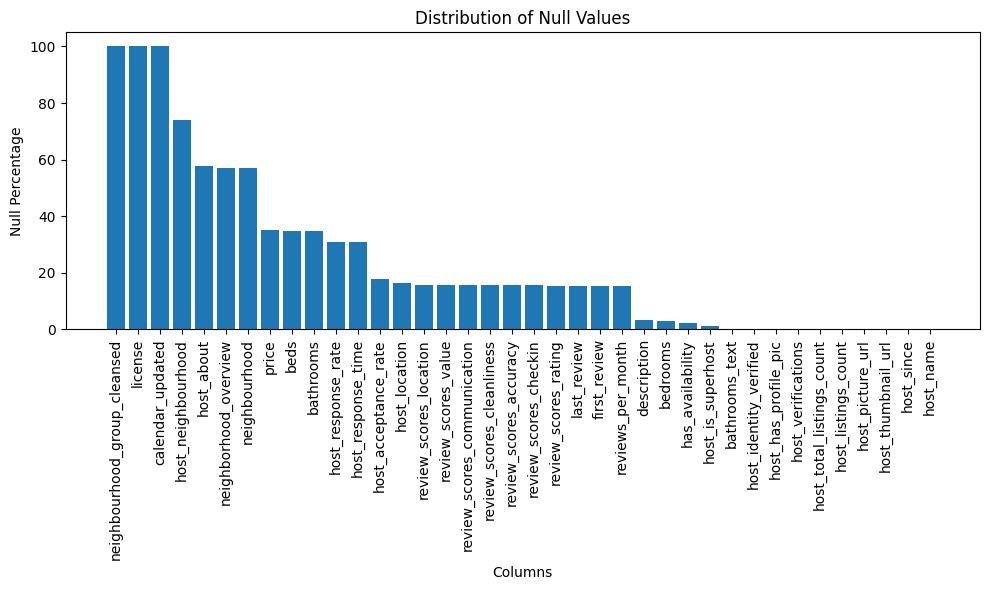

In [80]:
# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(null_info_sorted.index, null_info_sorted['Null_Percentage'])
plt.xlabel("Columns")
plt.ylabel("Null Percentage")
plt.title("Distribution of Null Values")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## 3.2 Host growth rate

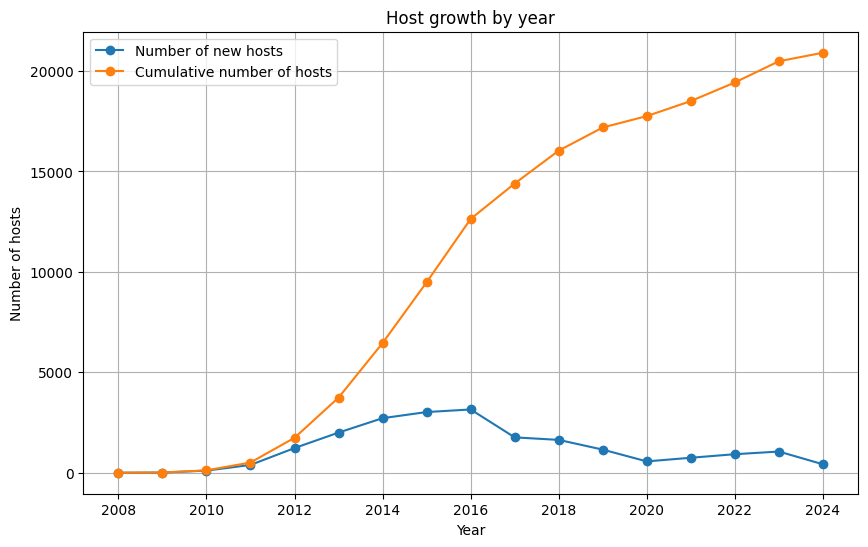

In [81]:
listings['host_since'] = pd.to_datetime(listings['host_since']) # Convert to datetime
listings['year'] = listings['host_since'].dt.year # Extract year

id_counts_by_year = listings.groupby('year')['id'].nunique().reset_index()

# Calculate cumulative sum of distinct IDs
id_counts_by_year['cumulative_ids'] = id_counts_by_year['id'].cumsum()

# Plot the data with cumulative line
plt.figure(figsize=(10, 6))
plt.plot(id_counts_by_year['year'], id_counts_by_year['id'], marker='o', label='Number of new hosts')
plt.plot(id_counts_by_year['year'], id_counts_by_year['cumulative_ids'], marker='o', label='Cumulative number of hosts')
plt.title('Host growth by year')
plt.xlabel('Year')
plt.ylabel('Number of hosts')
plt.grid(True)
plt.legend()
plt.show()


# 4. Data Preparation

## 4.1 Cleaning

### Drop missing value collumns

In [82]:
# Drop columns with more than 99% missing values
threshold = 0.99
columns_to_drop = listings.columns[listings.isnull().mean() > threshold]
listings = listings.drop(columns=columns_to_drop)

### Convert bedrooms with NaN to 0

In [83]:
# Convert bedrooms with NaN to 0
listings['bedrooms'] = listings['bedrooms'].fillna(0)
# Convert to integer
listings['bedrooms'] = listings['bedrooms'].astype(int)

### Number_of_reviews_ltm

48.0
Average (capped at 95th percentile, not excluding 0s): 4.876990769525085


Text(0.5, 0, 'number_of_reviews_ltm')

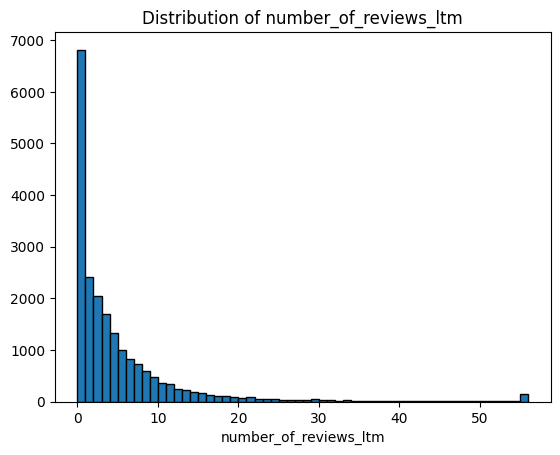

In [84]:
# Step 1: Filter out rows where number_of_reviews_ltm is 0
avg_filter = listings['number_of_reviews_ltm']

# Step 2: Compute the 95th percentile
p95 = avg_filter.quantile(0.99) #Access the values in the Series directly.
print(p95)
# Step 3: Cap values above the 95th percentile
avg_filter_capped = np.where(
    avg_filter > 56,
    56,
    avg_filter
)
#Store capped values in a new variable

# Step 4: Calculate the average of the capped values
average_capped = avg_filter_capped.mean() # Calculate the mean of the capped values

print(f"Average (capped at 95th percentile, not excluding 0s): {average_capped}")

# Histogram of average_capped
plt.hist(avg_filter_capped, bins=56, edgecolor='black') #Plot the capped values
plt.title('Distribution of number_of_reviews_ltm')
plt.xlabel('number_of_reviews_ltm')

## 4.2 Formatting

### Boolean

In [85]:
# Ensure 'host_is_superhost' column is properly treated as boolean
listings['host_is_superhost'] = listings['host_is_superhost'].map({'t': True, 'f': False})

# Ensure 'host_has_profle_pic' column is properly treated as boolean
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map({'t': True, 'f': False})

# Ensure 'host_identity_verified' column is properly treated as boolean
listings['host_identity_verified'] = listings['host_identity_verified'].map({'t': True, 'f': False})

# Ensure 'host_identity_verified' column is properly treated as boolean
listings['instant_bookable'] = listings['instant_bookable'].map({'t': True, 'f': False})


### Correcting neighbourhood names

In [86]:
# Correct neighbourhood names
neighbourhood_mapping = {
    'Vesterbro-Kongens Enghave': 'Vesterbro-Kongens Enghave',
    'Nrrebro': 'Nørrebro',
    'Amager st': 'Amager Øst',
    'sterbro': 'Østerbro',
    'Indre By': 'Indre By',
    'Bispebjerg': 'Bispebjerg',
    'Amager Vest': 'Amager Vest',
    'Valby': 'Valby',
    'Frederiksberg': 'Frederiksberg',
    'Vanlse': 'Vanløse',
    'Brnshj-Husum': 'Brønshøj-Husum'
}

# Replace the values in the 'neighbourhood_cleansed' column with the correct names
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].replace(neighbourhood_mapping)

### Change format of price variable

In [87]:
listings['price'][1]

'$1,865.00'

In [88]:
# Remove dollarsign and turn into float
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
# Set entries with price as 0 to NaN
listings.loc[listings['price'] == 0, 'price'] = np.nan
# Change name to price_dkk
listings.rename(columns={'price': 'price_dkk'}, inplace=True)

In [89]:
listings['price_dkk'][1]

np.float64(1865.0)

# 5. Data Analysis

## 5.1 Neighbourhoods

In [90]:
len(listings['neighbourhood_cleansed'].unique())

11

In [91]:
neighbourhood_list = listings['neighbourhood_cleansed'].unique().tolist()
neighbourhood_list

['Vesterbro-Kongens Enghave',
 'Nørrebro',
 'Amager Øst',
 'Østerbro',
 'Indre By',
 'Bispebjerg',
 'Amager Vest',
 'Valby',
 'Frederiksberg',
 'Vanløse',
 'Brønshøj-Husum']

In [92]:
# Iterate through the list and create filtered DataFrames
dataframes = {}
for neighbourhood in neighbourhood_list:
    dataframes[neighbourhood] = listings[listings['neighbourhood_cleansed'] == neighbourhood]

### Number of entries

In [93]:
# Count the number of entries in each DataFrame
entries_count = {name: df.shape[0] for name, df in dataframes.items()}
entries_count

{'Vesterbro-Kongens Enghave': 3588,
 'Nørrebro': 3734,
 'Amager Øst': 1572,
 'Østerbro': 2248,
 'Indre By': 2998,
 'Bispebjerg': 990,
 'Amager Vest': 1869,
 'Valby': 821,
 'Frederiksberg': 2200,
 'Vanløse': 523,
 'Brønshøj-Husum': 366}

### Average Prices

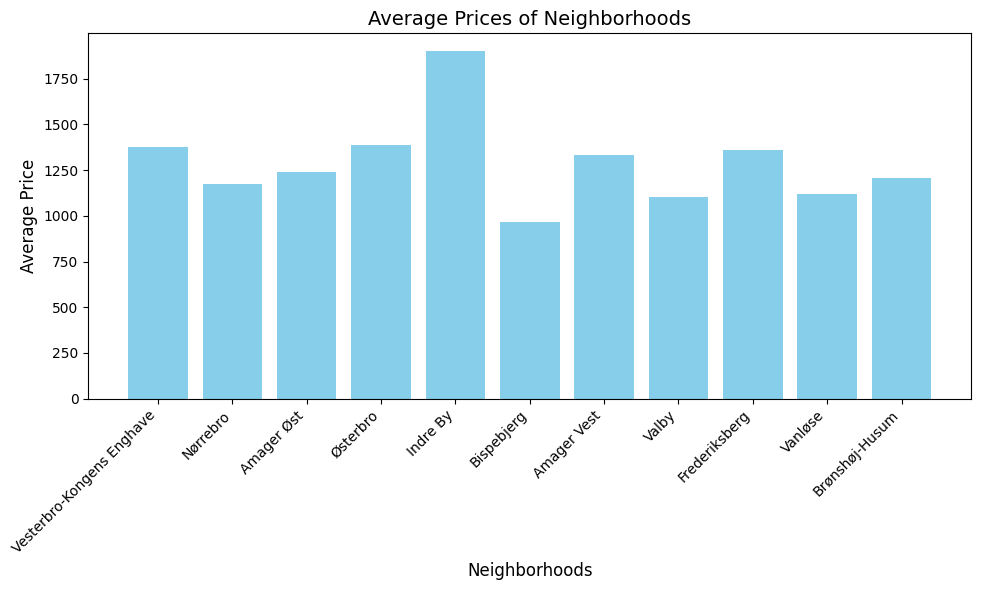

In [94]:
# Calculate the average price for each neighborhood
average_prices = {name: df['price_dkk'].mean() for name, df in dataframes.items()}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_prices.keys(), average_prices.values(), color='skyblue')

# Add labels and title
plt.xlabel('Neighborhoods', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.title('Average Prices of Neighborhoods', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the chart
plt.tight_layout()
plt.show()

## 5.2 Room types

### Distribution of room types in each neighbourhood

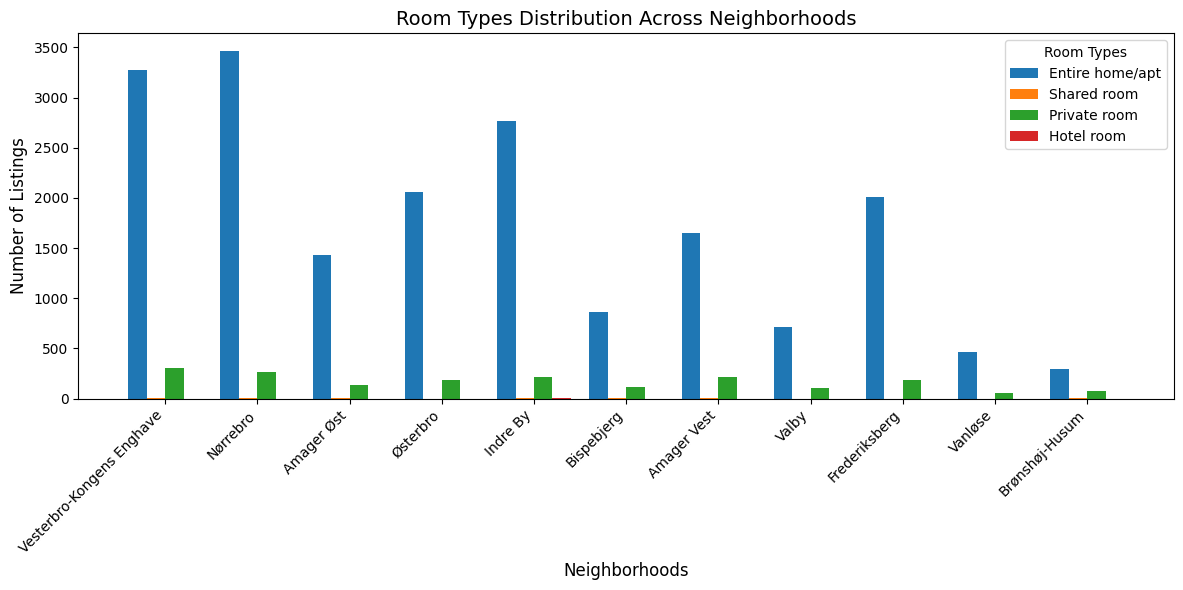

In [95]:
# Get the list of unique room types
room_type_list = listings['room_type'].unique().tolist()

# Count room types for each neighborhood
room_type_counts = {name: df['room_type'].value_counts() for name, df in dataframes.items()}

# Prepare data for plotting
plot_data = {}
for neighborhood, counts in room_type_counts.items():
    for room_type in room_type_list:
        plot_data.setdefault(room_type, []).append(counts.get(room_type, 0))

# Plotting
x = list(dataframes.keys())
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each room type
for i, room_type in enumerate(room_type_list):
    ax.bar([pos + i * bar_width for pos in range(len(x))], plot_data[room_type], bar_width, label=room_type)

# Add labels and title
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
ax.set_title('Room Types Distribution Across Neighborhoods', fontsize=14)
ax.set_xticks([pos + bar_width * (len(room_type_list) - 1) / 2 for pos in range(len(x))])
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(title='Room Types')

# Display the chart
plt.tight_layout()
plt.show()


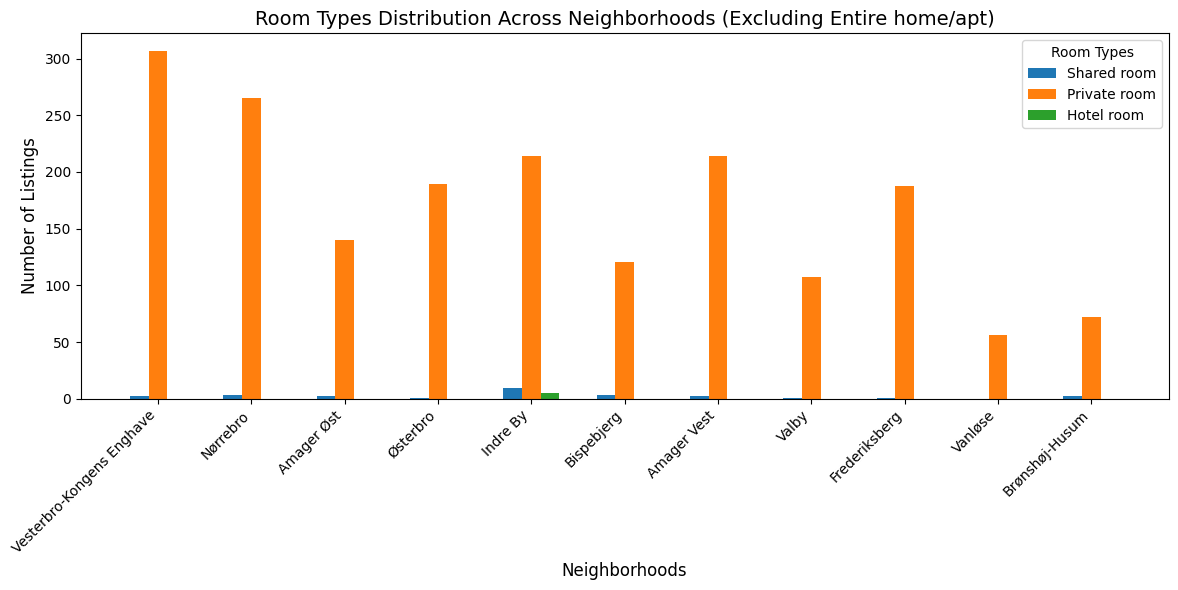

In [96]:
# Get the list of unique room types and exclude 'Entire home/apt'
room_type_list = [room_type for room_type in listings['room_type'].unique().tolist() if room_type != 'Entire home/apt']

# Count room types for each neighborhood
room_type_counts = {name: df['room_type'].value_counts() for name, df in dataframes.items()}

# Prepare data for plotting
plot_data = {}
for neighborhood, counts in room_type_counts.items():
    for room_type in room_type_list:
        plot_data.setdefault(room_type, []).append(counts.get(room_type, 0))

# Plotting
x = list(dataframes.keys())
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each room type
for i, room_type in enumerate(room_type_list):
    ax.bar([pos + i * bar_width for pos in range(len(x))], plot_data[room_type], bar_width, label=room_type)

# Add labels and title
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
ax.set_title('Room Types Distribution Across Neighborhoods (Excluding Entire home/apt)', fontsize=14)
ax.set_xticks([pos + bar_width * (len(room_type_list) - 1) / 2 for pos in range(len(x))])
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(title='Room Types')

# Display the chart
plt.tight_layout()
plt.show()


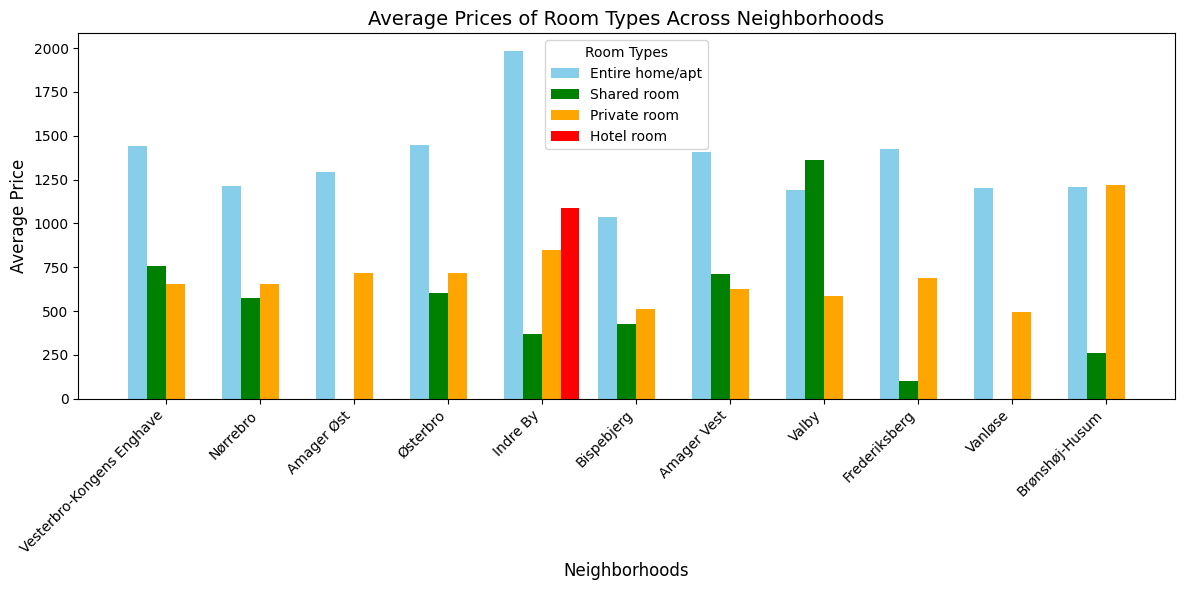

In [97]:
import matplotlib.pyplot as plt

# Example initialization of room_type_list
room_type_list = listings['room_type'].unique().tolist()

# Define fixed colors for room types
room_type_colors = {
    'Entire home/apt': 'skyblue',
    'Private room': 'orange',
    'Shared room': 'green',
    'Hotel room': 'red'
}

# Calculate average prices for each room type in each neighborhood
average_price_data = {}
for neighborhood, df in dataframes.items():
    average_price_data[neighborhood] = {
        room_type: df[df['room_type'] == room_type]['price_dkk'].mean()
        for room_type in room_type_list
    }

# Prepare data for plotting
plot_data = {room_type: [] for room_type in room_type_list}
for neighborhood, room_type_prices in average_price_data.items():
    for room_type in room_type_list:
        plot_data[room_type].append(room_type_prices.get(room_type, 0))

# Plotting
x = list(dataframes.keys())
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each room type
for i, room_type in enumerate(room_type_list):
    ax.bar([pos + i * bar_width for pos in range(len(x))],
           plot_data[room_type],
           bar_width,
           label=room_type,
           color=room_type_colors[room_type])

# Add labels and title
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Average Price', fontsize=12)
ax.set_title('Average Prices of Room Types Across Neighborhoods', fontsize=14)
ax.set_xticks([pos + bar_width * (len(room_type_list) - 1) / 2 for pos in range(len(x))])
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(title='Room Types')

# Display the chart
plt.tight_layout()
plt.show()


## 5.3 Accomodates

In [98]:
# Define accommodate groups for all neighborhoods
accommodates_groups = {
    neighborhood: {
        '1-2_accommodates': df[(df['accommodates'] >= 1) & (df['accommodates'] <= 2)],
        '3-4_accommodates': df[(df['accommodates'] >= 3) & (df['accommodates'] <= 4)],
        '5-6_accommodates': df[(df['accommodates'] >= 5) & (df['accommodates'] <= 6)],
        '7+_accommodates': df[df['accommodates'] >= 7]
    }
    for neighborhood, df in dataframes.items()
}


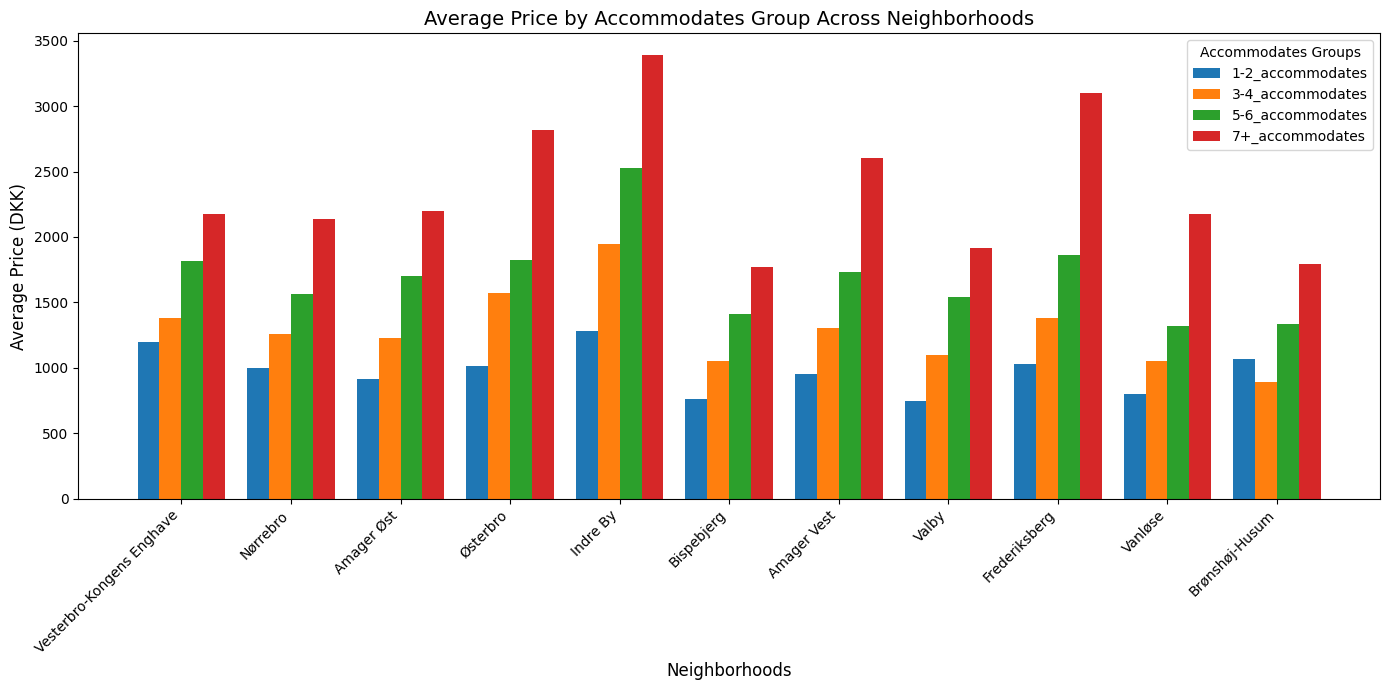

In [99]:
import matplotlib.pyplot as plt

# Calculate average prices for the updated accommodates groups
average_prices_accommodates = {
    neighborhood: {group: df['price_dkk'].mean() for group, df in groups.items()}
    for neighborhood, groups in accommodates_groups.items()
}

# Prepare data for plotting
categories = ['1-2_accommodates', '3-4_accommodates', '5-6_accommodates', '7+_accommodates']
plot_data = {category: [] for category in categories}

# Populate plot data
for neighborhood, averages in average_prices_accommodates.items():
    for category in categories:
        plot_data[category].append(averages.get(category, 0))  # Use 0 if category not present

# Plotting
x = list(accommodates_groups.keys())  # Neighborhood names
bar_width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for each group
for i, category in enumerate(categories):
    ax.bar(
        [pos + i * bar_width for pos in range(len(x))],
        plot_data[category],
        bar_width,
        label=category
    )

# Add labels and title
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Average Price (DKK)', fontsize=12)
ax.set_title('Average Price by Accommodates Group Across Neighborhoods', fontsize=14)
ax.set_xticks([pos + bar_width * (len(categories) - 1) / 2 for pos in range(len(x))])
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend(title='Accommodates Groups')

# Display the chart
plt.tight_layout()
plt.show()


In [100]:
# Calculate statistics for each neighborhood and accommodates group
detailed_descriptions = {}

for neighborhood, groups in accommodates_groups.items():
    detailed_descriptions[neighborhood] = {}
    for group, df in groups.items():
        if not df.empty:  # Ensure the DataFrame is not empty
            detailed_descriptions[neighborhood][group] = {
                'mean_price': df['price_dkk'].mean(),
                'max_price': df['price_dkk'].max(),
                'min_price': df['price_dkk'].min(),
                'total_listings': df.shape[0]
            }
        else:
            detailed_descriptions[neighborhood][group] = {
                'mean_price': None,
                'max_price': None,
                'min_price': None,
                'total_listings': 0
            }

# Display the descriptions
import pandas as pd
result = []

for neighborhood, groups in detailed_descriptions.items():
    for group, stats in groups.items():
        result.append({
            'Neighborhood': neighborhood,
            'Accommodates Group': group,
            **stats
        })

# Convert to DataFrame 
description_df = pd.DataFrame(result)
description_df

,Neighborhood,Accommodates Group,mean_price,max_price,min_price,total_listings
0,Vesterbro-Kongens Enghave,1-2_accommodates,1194.713307,100000.0,241.0,1667
1,Vesterbro-Kongens Enghave,3-4_accommodates,1383.305804,4350.0,280.0,1376
2,Vesterbro-Kongens Enghave,5-6_accommodates,1819.245161,8000.0,495.0,475
3,Vesterbro-Kongens Enghave,7+_accommodates,2173.215686,6929.0,261.0,70
4,Nørrebro,1-2_accommodates,997.806897,12000.0,240.0,1897
5,Nørrebro,3-4_accommodates,1258.148320,3600.0,467.0,1399
6,Nørrebro,5-6_accommodates,1563.932000,10000.0,599.0,379
7,Nørrebro,7+_accommodates,2136.170732,12500.0,750.0,59
8,Amager Øst,1-2_accommodates,915.745455,10000.0,199.0,704
9,Amager Øst,3-4_accommodates,1225.177177,4150.0,240.0,506


### 5.4 Reviews

In [101]:
# Calculate the mean of 'number_of_reviews' for all groups in all neighborhoods
num_reviews_mean = {}

for neighborhood, groups in accommodates_groups.items():
    num_reviews_mean[neighborhood] = {}
    for group_name, df in groups.items():
        if not df.empty:  # Ensure there are data points
            mean_review = df['number_of_reviews'].mean()
            num_reviews_mean[neighborhood][group_name] = mean_review
        else:
            # If the DataFrame is empty, set mean as None
            num_reviews_mean[neighborhood][group_name] = None


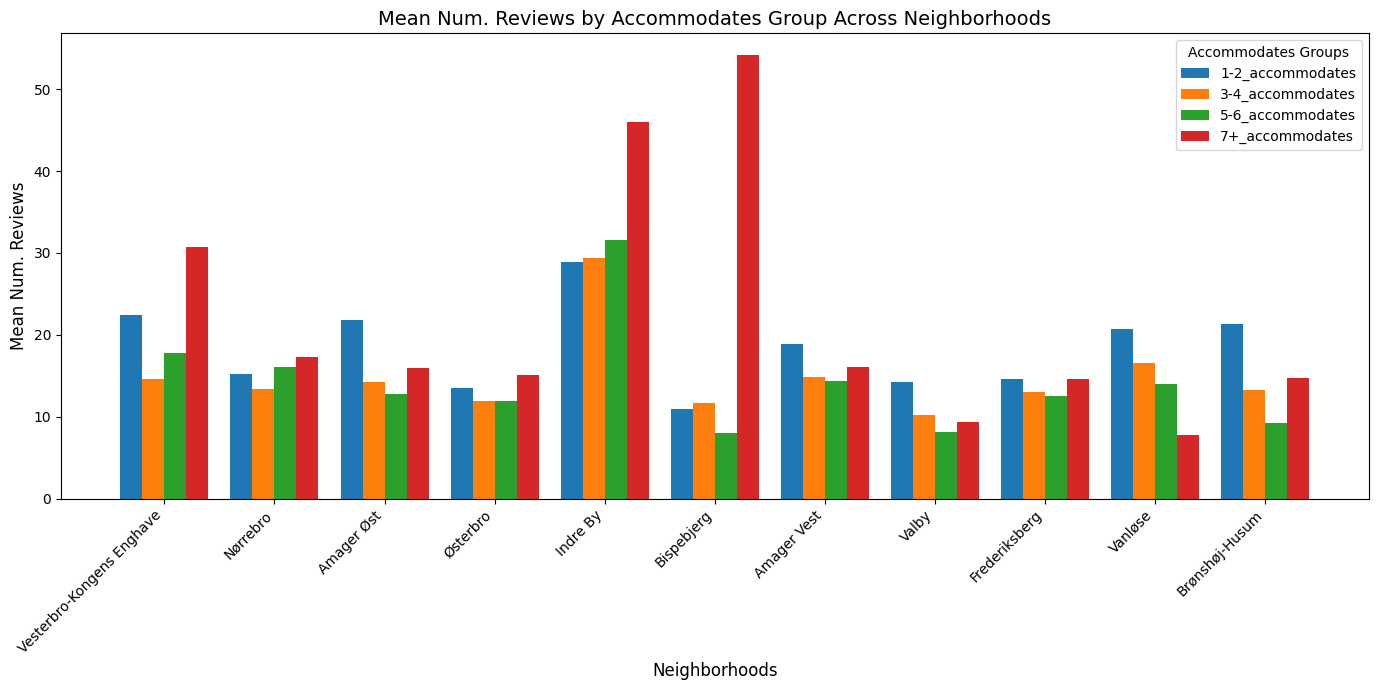

In [102]:
import matplotlib.pyplot as plt

# Prepare data for plotting
neighborhoods = list(num_reviews_mean.keys())
categories = ['1-2_accommodates', '3-4_accommodates', '5-6_accommodates', '7+_accommodates']

plot_data = {category: [] for category in categories}
for neighborhood, groups in num_reviews_mean.items():
    for category in categories:
        plot_data[category].append(groups.get(category, 0))

# Plotting
bar_width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each category
for i, category in enumerate(categories):
    ax.bar(
        [pos + i * bar_width for pos in range(len(neighborhoods))],
        plot_data[category],
        bar_width,
        label=category
    )

# Customize the plot
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Mean Num. Reviews', fontsize=12)
ax.set_title('Mean Num. Reviews by Accommodates Group Across Neighborhoods', fontsize=14)
ax.set_xticks([pos + bar_width * (len(categories) - 1) / 2 for pos in range(len(neighborhoods))])
ax.set_xticklabels(neighborhoods, rotation=45, ha='right')
ax.legend(title='Accommodates Groups')

# Display the chart
plt.tight_layout()
plt.show()


In [103]:
# Initialize a dictionary to store counts and percentages
review_counts_with_percentages = {}

# Iterate through all neighborhoods in dataframes
for neighborhood, df in dataframes.items():
    if 'number_of_reviews' in df.columns:  # Ensure the column exists
        nan_count = df['number_of_reviews'].isna().sum()
        zero_count = (df['number_of_reviews'] == 0).sum()
        non_zero_non_nan_count = df['number_of_reviews'].count() - zero_count

        # Calculate total invalid (NaN + Zero) and percentage
        total_invalid = nan_count + zero_count
        if total_invalid + non_zero_non_nan_count > 0:
            invalid_percentage = (total_invalid / (total_invalid + non_zero_non_nan_count)) * 100
        else:
            invalid_percentage = 0
        
        review_counts_with_percentages[neighborhood] = {
            'NaN': nan_count,
            'Zero': zero_count,
            'Non-Zero/Non-NaN': non_zero_non_nan_count,
            'Invalid Percentage': invalid_percentage
        }

# Print the results
for neighborhood, counts in review_counts_with_percentages.items():
    print(f"\nNeighborhood: {neighborhood}")
    print(f"  NaN values: {counts['NaN']}")
    print(f"  Zero values: {counts['Zero']}")
    print(f"  Non-Zero/Non-NaN values: {counts['Non-Zero/Non-NaN']}")
    print(f"  Percentage: {counts['Invalid Percentage']:.2f}%")



Neighborhood: Vesterbro-Kongens Enghave
  NaN values: 0
  Zero values: 489
  Non-Zero/Non-NaN values: 3099
  Percentage: 13.63%

Neighborhood: Nørrebro
  NaN values: 0
  Zero values: 490
  Non-Zero/Non-NaN values: 3244
  Percentage: 13.12%

Neighborhood: Amager Øst
  NaN values: 0
  Zero values: 238
  Non-Zero/Non-NaN values: 1334
  Percentage: 15.14%

Neighborhood: Østerbro
  NaN values: 0
  Zero values: 421
  Non-Zero/Non-NaN values: 1827
  Percentage: 18.73%

Neighborhood: Indre By
  NaN values: 0
  Zero values: 391
  Non-Zero/Non-NaN values: 2607
  Percentage: 13.04%

Neighborhood: Bispebjerg
  NaN values: 0
  Zero values: 171
  Non-Zero/Non-NaN values: 819
  Percentage: 17.27%

Neighborhood: Amager Vest
  NaN values: 0
  Zero values: 326
  Non-Zero/Non-NaN values: 1543
  Percentage: 17.44%

Neighborhood: Valby
  NaN values: 0
  Zero values: 150
  Non-Zero/Non-NaN values: 671
  Percentage: 18.27%

Neighborhood: Frederiksberg
  NaN values: 0
  Zero values: 385
  Non-Zero/Non-NaN va

In [104]:
# Calculate the mean of 'number_of_reviews' for all groups in all neighborhoods
reviews_location_mean = {}

for neighborhood, groups in accommodates_groups.items():
    reviews_location_mean[neighborhood] = {}
    for group_name, df in groups.items():
        if not df.empty:  # Ensure there are data points
            mean_review = df['review_scores_location'].mean()
            reviews_location_mean[neighborhood][group_name] = mean_review
        else:
            # If the DataFrame is empty, set mean as None
            reviews_location_mean[neighborhood][group_name] = None

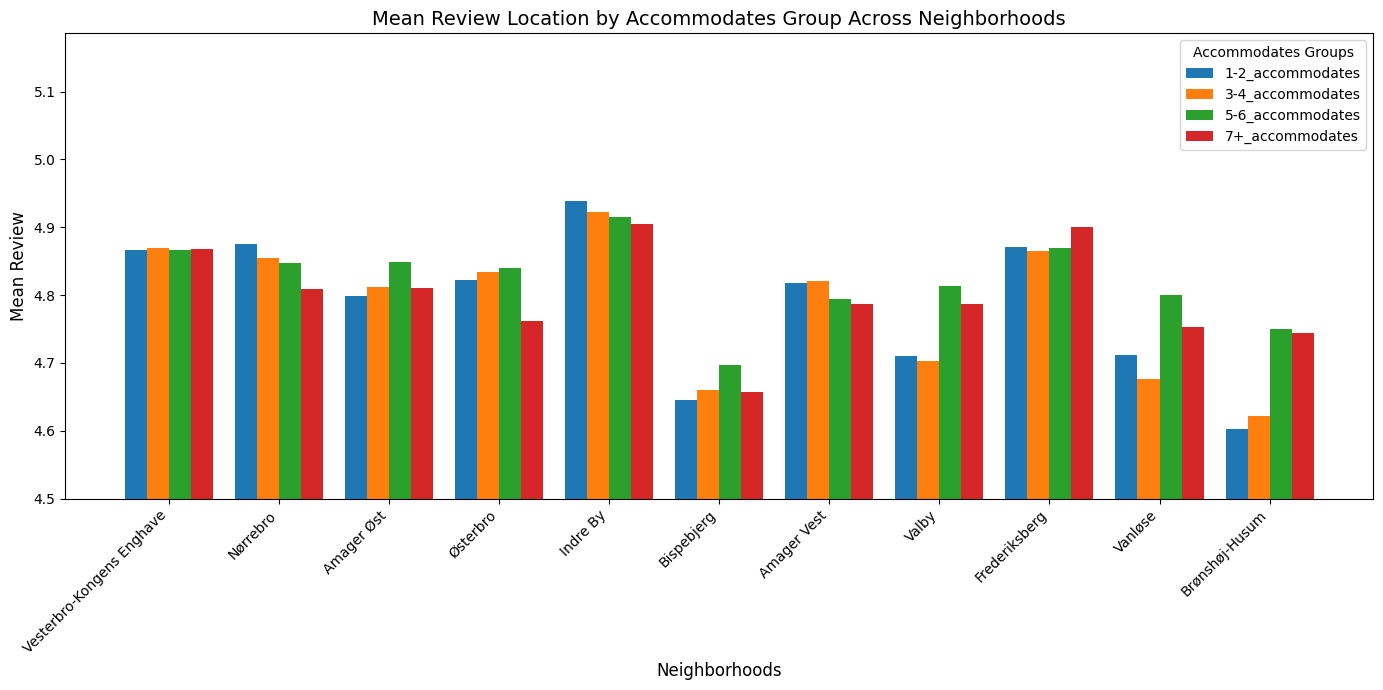

In [105]:
import matplotlib.pyplot as plt

# Prepare data for plotting
neighborhoods = list(num_reviews_mean.keys())
categories = ['1-2_accommodates', '3-4_accommodates', '5-6_accommodates', '7+_accommodates']

plot_data = {category: [] for category in categories}
for neighborhood, groups in reviews_location_mean.items():
    for category in categories:
        plot_data[category].append(groups.get(category, 0))

# Plotting
bar_width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each category
for i, category in enumerate(categories):
    ax.bar(
        [pos + i * bar_width for pos in range(len(neighborhoods))],
        plot_data[category],
        bar_width,
        label=category
    )

# Customize the plot
ax.set_xlabel('Neighborhoods', fontsize=12)
ax.set_ylabel('Mean Review', fontsize=12)
ax.set_title('Mean Review Location by Accommodates Group Across Neighborhoods', fontsize=14)
ax.set_xticks([pos + bar_width * (len(categories) - 1) / 2 for pos in range(len(neighborhoods))])
ax.set_xticklabels(neighborhoods, rotation=45, ha='right')
ax.legend(title='Accommodates Groups')

# Set the y-axis limit to start at 4
ax.set_ylim(4.5, ax.get_ylim()[1])

# Display the chart
plt.tight_layout()
plt.show()


# 6. Final Dataframe

## 6.1 Overview

In [106]:
# Define the columns to keep
columns_to_keep = [
    'id', 'accommodates', 'availability_365', 'bedrooms',
    'calculated_host_listings_count', 'description', 'host_about',
    'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified',
    'host_is_superhost', 'host_response_rate', 'host_response_time',
    'instant_bookable', 'neighbourhood_cleansed',
    'number_of_reviews_ltm', 'price_dkk', 'reviews_per_month', 'review_scores_accuracy',
    'review_scores_checkin', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_location',
    'review_scores_rating', 'review_scores_value', 'room_type', 'property_type'
]

# Create a new DataFrame with only the selected columns
listings_original = listings
listings_cleaned = listings[columns_to_keep]

# Print the number of columns in listings_cleaned
print(f'There are {listings_cleaned.shape[1]} variables in the listings_cleaned DataFrame.')



There are 27 variables in the listings_cleaned DataFrame.


## 6.2 Final Data Correlation

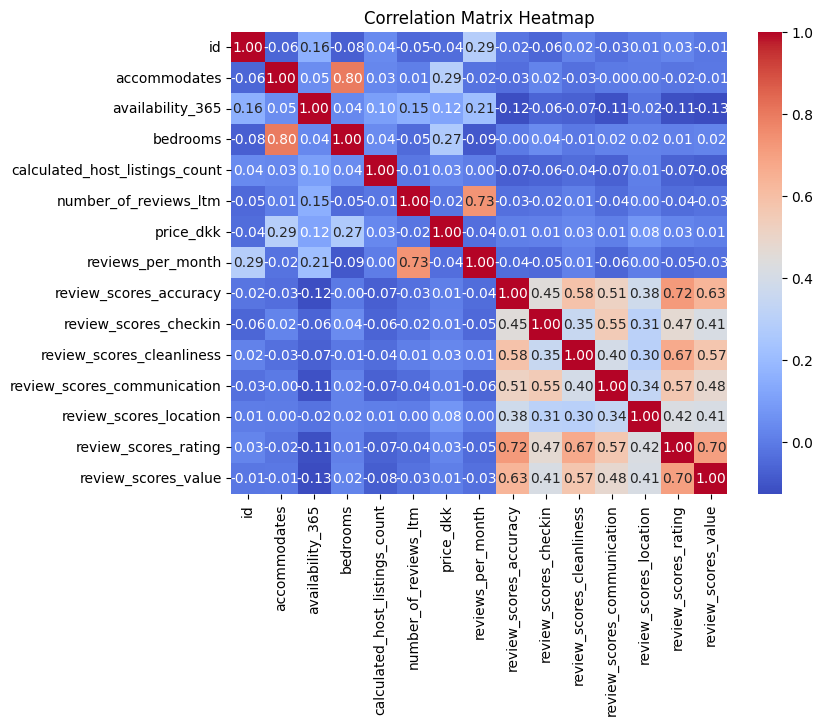

In [107]:
numeric_listings_cleaned = listings_cleaned.select_dtypes(include=['number'])
# Step 2: Compute correlation matrix
correlation_matrix = numeric_listings_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


## 6.3 Downloading 

**Export to a CSV file** 
output_file = 'listings_cleaned.csv'
listings_cleaned.to_csv(output_file, index=False)

**Print confirmation**
print(f"Filtered data saved to '{output_file}'")